# Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.stats import uniform
from sklearn import svm,tree,preprocessing
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,StratifiedKFold
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,average_precision_score
from sklearn.metrics import precision_recall_curve,plot_precision_recall_curve,precision_score

# Importing the [MAGIC Gamma Telescope Data Set](http://archive.ics.uci.edu/ml/datasets/magic+gamma+telescope)

### A brief about the Data
> The data are MC generated to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background).

>![Example](https://magic.mpp.mpg.de/fileadmin/site_files/pics/event_sequence.gif)

>Typically, the image of a shower after some pre-processing is an elongated cluster. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. If the depositions were distributed as a bivariate Gaussian, this would be an equidensity ellipse. The characteristic parameters of this ellipse (often called Hillas parameters) are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions.


### Downloading the data

In [2]:
MAGIC_dataset = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data", 
            header=None,
            names = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"])

In [3]:
data = MAGIC_dataset.copy()
print("Size of data: ", data.shape)
data.head()

Size of data:  (19020, 11)


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


### Data's statistical Info

In [4]:
data.describe()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
count,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000
mean,53.250154,22.180966,2.825017,0.380327,0.214657,-4.331745,10.545545,0.249726,27.645707,193.818026
std,42.364855,18.346056,0.472599,0.182813,0.110511,59.206062,51.000118,20.827439,26.103621,74.731787
min,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,1.282600
25%,24.336000,11.863800,2.477100,0.235800,0.128475,-20.586550,-12.842775,-10.849375,5.547925,142.492250
50%,37.147700,17.139900,2.739600,0.354150,0.196500,4.013050,15.314100,0.666200,17.679500,191.851450
75%,70.122175,24.739475,3.101600,0.503700,0.285225,24.063700,35.837800,10.946425,45.883550,240.563825
max,334.177000,256.382000,5.323300,0.893000,0.675200,575.240700,238.321000,179.851000,90.000000,495.561000


Note the features have very different scales.

-------------------
## Feature Engineering

In [5]:
print('Null value present?\t{}'.format(np.any(data.isnull())))

Null value present?	False


Finding redundant attributes by plotting pairplots. 

(19020, 10)


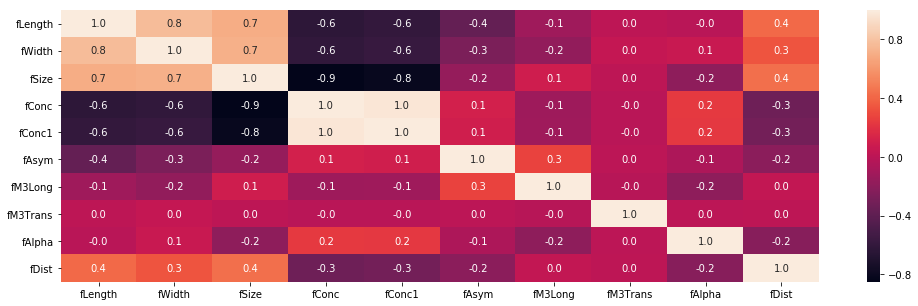

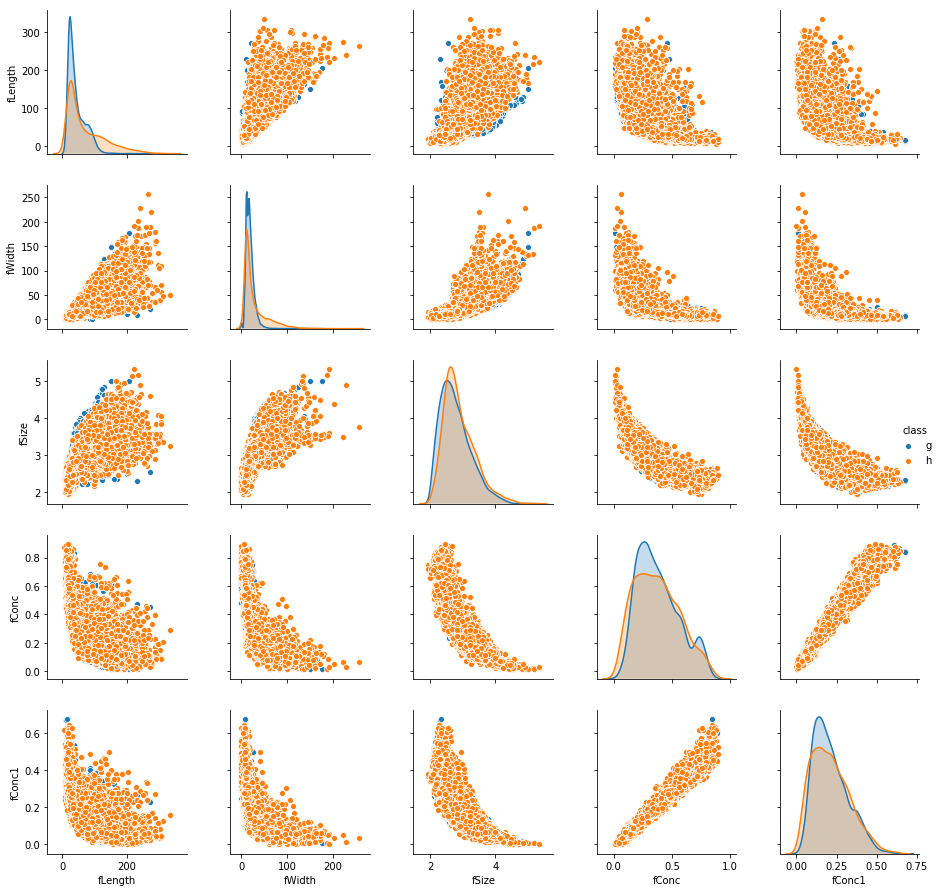

In [6]:
fig1 = sns.heatmap(data.corr(), annot=True, fmt=".1f", ax=plt.subplots(figsize=(17, 5))[1])
fig2 = sns.pairplot(data=data.loc[:, ["fLength", "fWidth", "fSize", "fConc", "fConc1", "class"]], hue='class')
data = data.drop(columns='fConc')
plt.tight_layout()
print(data.shape)

We see pairplots of only those features which had correlation >= 0.7 with any other feature. Note that pairplot was necessary as  correlation value can also become high if outliers are present. The 'fConc1' labeled feature vector was redundant with 'fConc' hence one of them was dropped. These two also follow a hyperbolic relation with fSize as their calculation has fSize as denomiantor.

Since after removing a column many rows could become same hence dropping redundant rows. 

In [7]:
prev = len(data)
data.drop_duplicates(inplace=True)
curr = len(data)
print("No of duplicate rows removed : {:,}".format(prev-curr))

No of duplicate rows removed : 115


For analysing each feature let's look at their violinplots.

In [8]:
X_l2 = (data._get_numeric_data() - data.mean(numeric_only=True))/data.std(numeric_only=True)

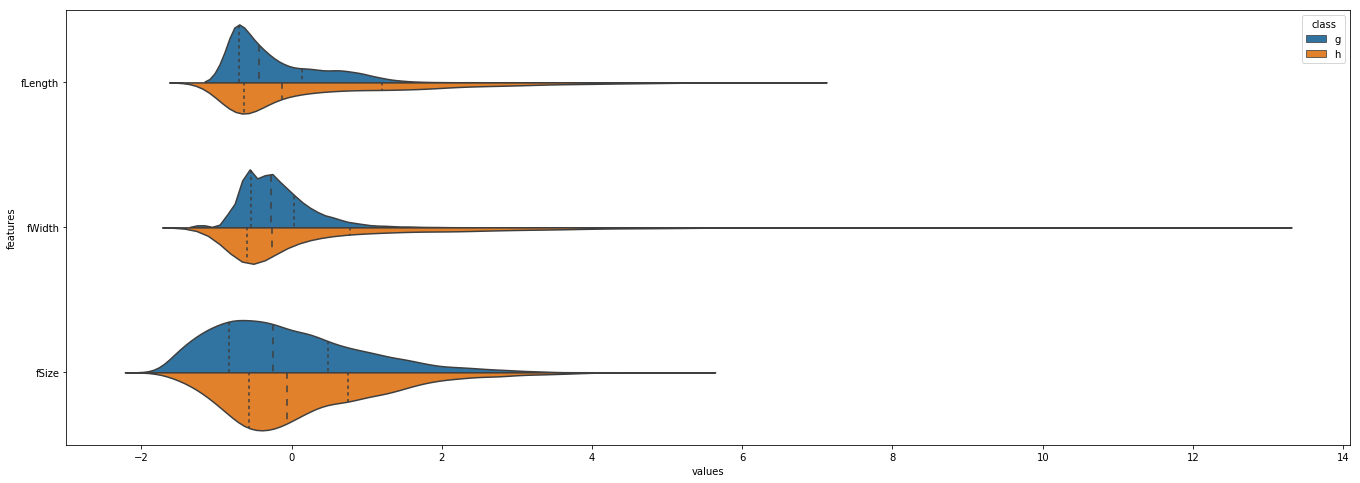

In [9]:
_ = pd.concat([X_l2.iloc[:, 0:3], data['class']], axis=1)
_ = _.melt(id_vars='class', var_name='features', value_name='values')
fig3_1 = sns.violinplot(x='values', y='features', hue='class', data=_, inner='quartiles', split=True,
                      ax=plt.subplots(figsize=(23, 8))[1], orient='h')

Inference - I
* These highly right skewed distributions indicate presence of outliers. 
* fWidth for class hadron has very highly right skewed data this can be explained as background noise may make irregular shapes which are not ellipse and hence width can be large for non-elliptical shapes. 

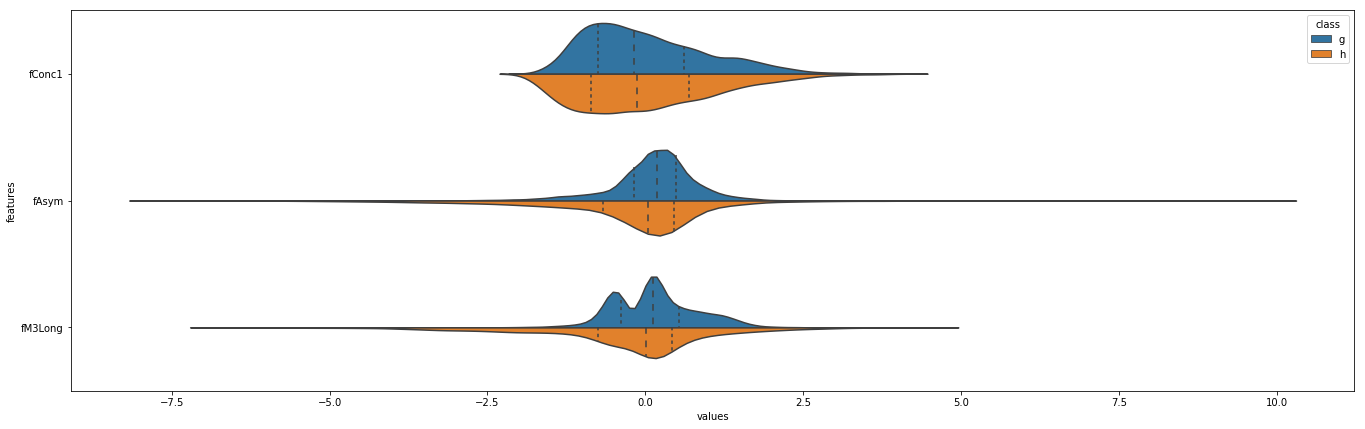

In [10]:
_ = pd.concat([X_l2.iloc[:, 3:6], data['class']], axis=1)
_ = _.melt(id_vars='class', var_name='features', value_name='values')
fig3_2 = sns.violinplot(x='values', y='features', hue='class', data=_, inner='quartiles', split=True,
                      ax=plt.subplots(figsize=(23, 7))[1], orient='h')

Inference - II
* This bimodal distribution of fM3Long represents that gamma class has a property that most these signals are either right or left skewed along major axis of ellipse as 3rd moment of a standardized data represent skewness.

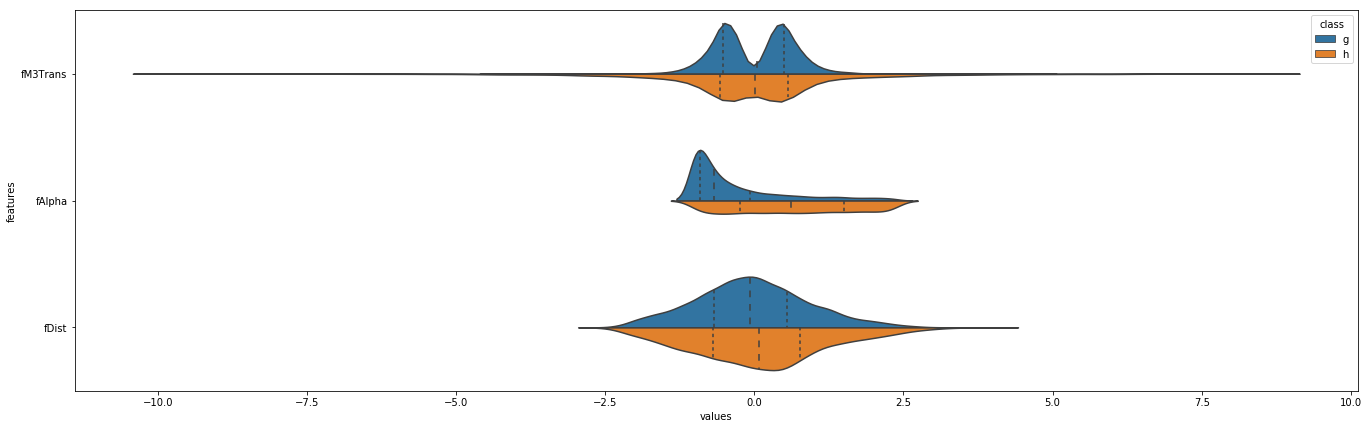

In [11]:
_ = pd.concat([X_l2.iloc[:, 6:], data['class']], axis=1)
_ = _.melt(id_vars='class', var_name='features', value_name='values')
fig3_3 = sns.violinplot(x='values', y='features', hue='class', data=_, inner='quartiles', split=True,
                      ax=plt.subplots(figsize=(23, 7))[1], orient='h')

Inference - III
* The feature fAlpha has relatively high potential to separate these classes as it has distinguishable median and distribution for respective classes.
* fM3Trans can be explained using the same reason as fM3Long done in Inference-II.

Let's look closer our target feature!

Count of gamma (signal) :	12,332 
Count of hadron (background):	6,573


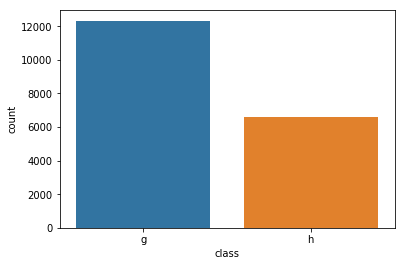

In [12]:
fig4 = sns.countplot(data['class'], label="Count")
g, h = data['class'].value_counts()
print('Count of gamma (signal) :\t{:,} \nCount of hadron (background):\t{:,}'.format(g, h))

Clearly data is **imbalanced** with nearly class ratio of 1:2 (g:h).

In [13]:
X = data.drop(columns='class')
y = data['class'].apply(lambda c: 1 if c=='h' else 0).astype(np.int64)
print(data.shape, X.shape, y.shape)

(18905, 10) (18905, 9) (18905,)


We choose **label 'h'** to be our **target class.**

## Initialisation

Stratified splitting of data for train and test examples to maintain the "imbalancy" while training too.

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
x_l2_train, x_l2_test, y_l2_train, y_l2_test = train_test_split(X_l2, y, test_size=0.3, random_state=0, stratify=y)
print("Training examples: {:}\tTesting examples: {:}\t".format(len(x_train), len(x_test)))

Training examples: 13233	Testing examples: 5672	


------------------
For classification we'll be trying different classifier until we get satisfactory results. Let's first try SVM.
# Classifying using SVM

* The range for hyperparameters C and Gamma are chosen intuitively.
* Due to class imbalancy balanced setting of hyperparameter C is chosen and 5 fold stratified Kfold is used while training.
* Since svm needs scaling l2 normalised data is used here. 
* Since both classes are equally important(which means F1 score should be high regardless of what pos_label is) average chosen is non-weighted mean of F1 score of both classes.

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.9min finished


	Accuracy = 0.8728843441466855	F1 score = 0.8587015751126161	average precision score = 0.9020109646955699


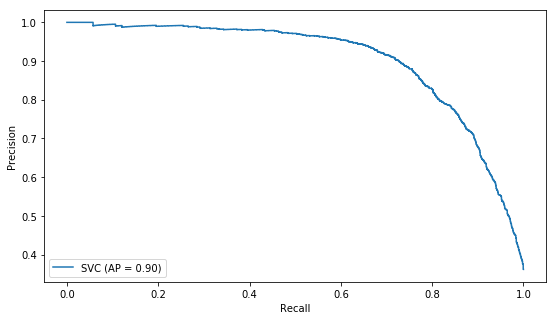

In [15]:
param_grid = {'C': [1, 10], 'gamma': [0.01, 0.1]}

clf = svm.SVC(kernel='rbf', probability=True, class_weight='balanced',random_state=42)
model = GridSearchCV(clf, param_grid, cv=5,verbose=1,scoring='f1')
model.fit(x_l2_train, np.ravel(y_l2_train))

svm_model = model.best_estimator_

accuracy = accuracy_score(y_l2_test, svm_model.predict(x_l2_test))
F1 = f1_score(y_l2_test, svm_model.predict(x_l2_test), average='macro')
average_precision = average_precision_score(y_l2_test, svm_model.decision_function(x_l2_test))
print("\tAccuracy = "+str(accuracy)+"\tF1 score = "+str(F1)+"\taverage precision score = "+str(average_precision))

fig5 = plot_precision_recall_curve(svm_model, x_l2_test, y_l2_test,ax=plt.subplots(figsize=(9,5))[1])

The reason of choosing PR curve over ROC is that ROC has negligible effects of class imbalancy issue unlike PR-Curve for example see below.
![PR curve over ROC](https://raw.githubusercontent.com/dariyasydykova/open_projects/master/ROC_animation/animations/imbalance.gif)
[[Source]](https://github.com/dariyasydykova/open_projects/tree/master/ROC_animation)

These results are acceptable but let's see if we can do better.

Let's look where are we taking loose. Earlier we manually removed one feature was it a bad move? To answer this question we can compare SVM with Decision Tree as it is more robust to the presence of correlated features. Besides this there are other advantages too of using it which are described in detail [here](https://scikit-learn.org/stable/modules/tree.html). 

# Classifying using Decision Tree

Splitting data again but with original data(i.e., including correlated features also)

In [16]:
X_raw = MAGIC_dataset.drop(columns='class')
y_raw = MAGIC_dataset['class'].apply(lambda c: 1 if c=='h' else 0).astype(np.int64)
x_raw_train, x_raw_test, y_raw_train, y_raw_test=train_test_split(X_raw, y_raw,
                                                                  test_size=0.3, random_state=0, stratify=y_raw)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    5.7s finished


	Accuracy = 0.8357868909919383	F1 score = 0.8224290234639493	average precision score = 0.8556824318635998


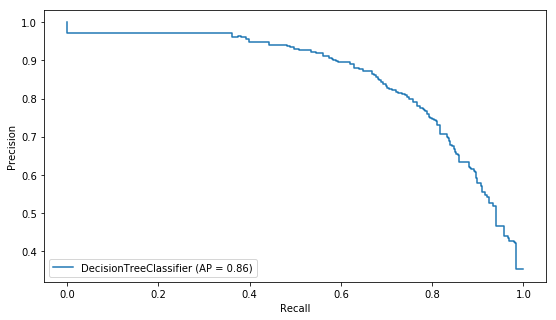

In [17]:
param_grid={'min_samples_leaf': range(1,100,10), 
            'criterion': ['gini','entropy'],
            'min_samples_split' : range(2,200,10),
            'max_depth': range(1,100,2)}

clf_tree = tree.DecisionTreeClassifier(class_weight='balanced')
model = RandomizedSearchCV(clf_tree,param_grid,verbose=1,cv=5,scoring='f1',random_state=42)
model.fit(x_raw_train, np.ravel(y_raw_train))

dt_model = model.best_estimator_

accuracy = accuracy_score(y_raw_test, dt_model.predict(x_raw_test))
F1 = f1_score(y_raw_test, dt_model.predict(x_raw_test), average='macro')
average_precision = average_precision_score(y_raw_test, dt_model.predict_proba(x_raw_test)[:,1])
print("\tAccuracy = "+str(accuracy)+"\tF1 score = "+str(F1)+"\taverage precision score = "+str(average_precision))

fig6 = plot_precision_recall_curve(dt_model, x_raw_test, y_raw_test,ax=plt.subplots(figsize=(9,5))[1])

The result worsened but we were hoping something else what happened? We could ask where & when can a decision tree fail. What are its cons? Well the [answer](https://scikit-learn.org/stable/modules/tree.html) suggests a possibility of it might be overfitting. As the problem of imbalancy was handeled by stratified sampling of cross-validation and balanced setting of class weight while training. 

So let's compare Random forrest now which has advantages of decision trees and but doesn't have its disadvantages. As these are ensemble classifiers of decision trees. But before that let's see if we were right about removing only 'fConc'.

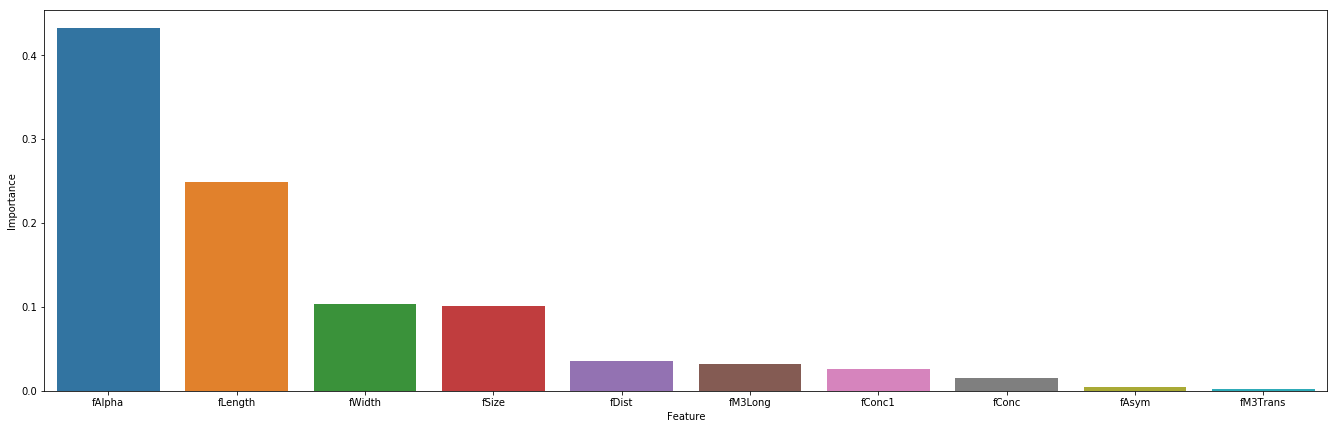

In [18]:
_ = pd.DataFrame({'Feature':X_raw.columns,'Importance':dt_model.feature_importances_}).sort_values(by='Importance',ascending=False)
fig7 = sns.barplot(x='Feature',y='Importance',data=_,ax=plt.subplots(figsize=(23,7))[1])

Its very evident now that only the first four parameters are sufficient enough to get the required result rest all features are not important for classification but since random forest isn't effected by feature elimination we'll use all features still.

# Classifying using RandomForest

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


	Accuracy = 0.883981773571679	F1 score = 0.8697183530931272	average precision score = 0.9105496724192043


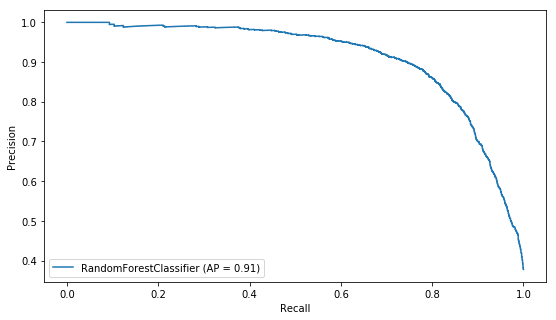

In [19]:
param_grid = {'criterion': ['gini', 'entropy'],
               'n_estimators': range(100,1000,100),
               'max_features': ['sqrt','None'],
               'max_depth': range(5,15,2)}

clf = RandomForestClassifier(n_jobs=-1,random_state=42,class_weight='balanced',oob_score=True)
model = RandomizedSearchCV(clf,param_grid,n_iter=10,cv=5,verbose=3,random_state=42,n_jobs=-1,scoring='f1')
model.fit(x_raw_train, np.ravel(y_raw_train))

rf_model = model.best_estimator_

accuracy = accuracy_score(y_raw_test, rf_model.predict(x_raw_test))
F1 = f1_score(y_raw_test, rf_model.predict(x_raw_test), average='macro')
average_precision = average_precision_score(y_raw_test, rf_model.predict_proba(x_raw_test)[:,1])
print("\tAccuracy = "+str(accuracy)+"\tF1 score = "+str(F1)+"\taverage precision score = "+str(average_precision))

fig8 = plot_precision_recall_curve(rf_model, x_raw_test, y_raw_test,ax=plt.subplots(figsize=(9,5))[1])

This result looks very promising. The reason of using an ensemble method over boosting is that boosting overfits easily than ensemblers. Hence they will always have performance poorer than or equal to that of ensemblers. Just for the sake of example see the below result of XGBoostClassifier. 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.7min finished


	Accuracy = 0.8824044865054329	F1 score = 0.8679643434763218	average precision score = 0.9151535353493038


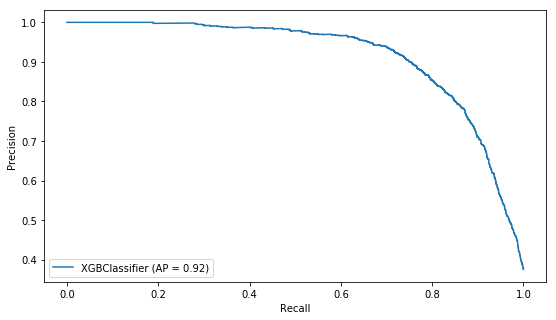

In [20]:
param_grid = {'n_estimators': range(100,1000,100),
               'max_depth': range(3,15,2),
               'learning_rate': uniform(0.03, 0.3),
               'subsample': uniform(0.6, 0.4),
               'colsample_bytree': uniform(0.7, 0.3),
               'gamma': uniform(0, 0.5)}

clf = xgb.XGBClassifier(objective='binary:logistic',n_jobs=4,random_state=42)
model = RandomizedSearchCV(clf,param_grid,n_iter=10,cv=5,verbose=3,random_state=42,n_jobs=-1,scoring='f1')
model.fit(x_raw_train, np.ravel(y_raw_train))

xgb_model = model.best_estimator_

accuracy = accuracy_score(y_raw_test, xgb_model.predict(x_raw_test))
F1 = f1_score(y_raw_test, xgb_model.predict(x_raw_test), average='macro')
average_precision = average_precision_score(y_raw_test, xgb_model.predict_proba(x_raw_test)[:,1])
print("\tAccuracy = "+str(accuracy)+"\tF1 score = "+str(F1)+"\taverage precision score = "+str(average_precision))

fig9 = plot_precision_recall_curve(xgb_model, x_raw_test, y_raw_test,ax=plt.subplots(figsize=(9,5))[1])

-----------------------
# Conclusion

The best result so far is given by Random Forest (Ensemble method). The highest scores by it are: 
> Accuracy = 0.883981773571679	F1 score = 0.8697183530931272	average precision score = 0.9105496724192043